<a href="https://colab.research.google.com/github/jacksonhmg/optimise_resnet_machine_learning_model_CIFAR10/blob/main/cifar_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0a0


In [ ]:
#Steps to use full CIFAR-10 data instead of demo data given by d2l
#1. Download the two files at https://drive.google.com/drive/folders/19pR1iTqmO9RZHEywxuDiKfmbp6KTQqUY
#2. Go to your google drive, make a folder at the root dir named 'data'
#3. Upload the two files you downloaded into the 'data' file
#4. Uncomment the below code and run it
#5. Go the files section in this session (left most nav bar)
#6. Create a new folder in the immediate directory it gives you when you open the file navigator
#7. Name that folder 'cifar-10'
#8. From the newly created test and train folders you created from running the code below, drag them into the 'cifar-10' folder
#9. Go to the kaggle link below and download the full cifar-10 files, unzip it. 
#10. Now that you have unzipped the 'trainLabels.csv' and the 'sampleSubmission.csv' files, drag them into this google colab session and into the 'cifar-10' folder you created
#11. You should now have the 2 folders and the two csv's in the 'cifar-10' folder
#12. Comment out the code below
#13. Go to where "demo = " in one of the cells below, make sure you set it to false
#14. Run the whole code

#If you want to swap back between the demo data, all you have to do is change that variable 
#(unless your runtime session disconnects and then you'll have to redo all those last steps to get the full data back')

#Code!!! :

#from google.colab import drive
#drive.mount('/content/gdrive')
#!unzip gdrive/MyDrive/data/train.zip
#!unzip gdrive/MyDrive/data/test.zip

# Image Classification (CIFAR-10) on Kaggle
:label:`sec_kaggle_cifar10`

So far, we have been using high-level APIs of deep learning frameworks to directly obtain image datasets in tensor format.
However, custom image datasets
often come in the form of image files.
In this section, we will start from
raw image files,
and organize, read, then transform them
into tensor format step by step.

We experimented with the CIFAR-10 dataset in :numref:`sec_image_augmentation`,
which is an important dataset in computer vision.
In this section,
we will apply the knowledge we learned
in previous sections
to practice the Kaggle competition of
CIFAR-10 image classification.
(**The web address of the competition is https://www.kaggle.com/c/cifar-10**)

:numref:`fig_kaggle_cifar10` shows the information on the competition's webpage.
In order to submit the results,
you need to register a Kaggle account.

![CIFAR-10 image classification competition webpage information. The competition dataset can be obtained by clicking the "Data" tab.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/kaggle-cifar10.png?raw=1)
:width:`600px`
:label:`fig_kaggle_cifar10`


In [ ]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import time

## Obtaining and Organizing the Dataset

The competition dataset is divided into
a training set and a test set,
which contain 50000 and 300000 images, respectively.
In the test set,
10000 images will be used for evaluation,
while the remaining 290000 images will not
be evaluated:
they are included just
to make it hard
to cheat with
*manually* labeled results of the test set.
The images in this dataset
are all png color (RGB channels) image files,
whose height and width are both 32 pixels.
The images cover a total of 10 categories, namely airplanes, cars, birds, cats, deer, dogs, frogs, horses, boats, and trucks.
The upper-left corner of :numref:`fig_kaggle_cifar10` shows some images of airplanes, cars, and birds in the dataset.


### Downloading the Dataset

After logging in to Kaggle, we can click the "Data" tab on the CIFAR-10 image classification competition webpage shown in :numref:`fig_kaggle_cifar10` and download the dataset by clicking the "Download All" button.
After unzipping the downloaded file in `../data`, and unzipping `train.7z` and `test.7z` inside it, you will find the entire dataset in the following paths:

* `../data/cifar-10/train/[1-50000].png`
* `../data/cifar-10/test/[1-300000].png`
* `../data/cifar-10/trainLabels.csv`
* `../data/cifar-10/sampleSubmission.csv`

where the `train` and `test` directories contain the training and testing images, respectively, `trainLabels.csv` provides labels for the training images, and `sample_submission.csv` is a sample submission file.

To make it easier to get started, [**we provide a small-scale sample of the dataset that
contains the first 1000 training images and 5 random testing images.**]
To use the full dataset of the Kaggle competition, you need to set the following `demo` variable to `False`.


In [ ]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')
# If you use the full dataset downloaded for the Kaggle competition, set
# `demo` to False
demo = True
if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = 'cifar-10/'

### [**Organizing the Dataset**]

We need to organize datasets to facilitate model training and testing.
Let's first read the labels from the csv file.
The following function returns a dictionary that maps
the non-extension part of the filename to its label.


In [ ]:
def read_csv_labels(fname):
    """Read `fname` to return a filename to label dictionary."""
    with open(fname, 'r') as f:
        # Skip the file header line (column name)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# training examples:', len(labels))
print('# classes:', len(set(labels.values())))

# training examples: 50000
# classes: 10


Next, we define the `reorg_train_valid` function to [**split the validation set out of the original training set.**]
The argument `valid_ratio` in this function is the ratio of the number of examples in the validation set to the number of examples in the original training set.
More concretely,
let $n$ be the number of images of the class with the least examples, and $r$ be the ratio.
The validation set will split out
$\max(\lfloor nr\rfloor,1)$ images for each class.
Let's use `valid_ratio=0.1` as an example. Since the original training set has 50000 images,
there will be 45000 images used for training in the path `train_valid_test/train`,
while the other 5000 images will be split out
as validation set in the path `train_valid_test/valid`. After organizing the dataset, images of the same class will be placed under the same folder.


In [ ]:
def copyfile(filename, target_dir):
    """Copy a file into a target directory."""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    """Split the validation set out of the original training set."""
    # The number of examples of the class that has the fewest examples in the
    # training dataset
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # The number of examples per class for the validation set
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label

The `reorg_test` function below [**organizes the testing set for data loading during prediction.**]


In [ ]:
def reorg_test(data_dir):
    """Organize the testing set for data loading during prediction."""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

Finally, we use a function to [**invoke**]
the `read_csv_labels`, `reorg_train_valid`, and `reorg_test` (**functions defined above.**)


In [ ]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

Here we only set the batch size to 32 for the small-scale sample of the dataset.
When training and testing
the complete dataset of the Kaggle competition,
`batch_size` should be set to a larger integer, such as 128.
We split out 10% of the training examples as the validation set for tuning hyperparameters.


In [ ]:
batch_size = 32 if demo else 128
#batch_size = 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

## [**Image Augmentation**]

We use image augmentation to address overfitting.
For example, images can be flipped horizontally at random during training.
We can also perform standardization for the three RGB channels of color images. Below lists some of these operations that you can tweak.


In [ ]:
transform_train = torchvision.transforms.Compose([
    # Scale the image up to a square of 40 pixels in both height and width
    torchvision.transforms.Resize(40),
    # Randomly crop a square image of 40 pixels in both height and width to
    # produce a small square of 0.64 to 1 times the area of the original
    # image, and then scale it to a square of 32 pixels in both height and
    # width
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # Standardize each channel of the image
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

During testing,
we only perform standardization on images
so as to
remove randomness in the evaluation results.


In [ ]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

## Reading the Dataset

Next, we [**read the organized dataset consisting of raw image files**]. Each example includes an image and a label.


In [ ]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

During training,
we need to [**specify all the image augmentation operations defined above**].
When the validation set
is used for model evaluation during hyperparameter tuning,
no randomness from image augmentation should be introduced.
Before final prediction,
we train the model on the combined training set and validation set to make full use of all the labeled data.


In [ ]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

## Defining the [**Model**]


We define the ResNet-18 model described in
:numref:`sec_resnet`.


In [ ]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        #Y = F.relu(self.bn1(self.conv1(X)))
        #Y = self.bn2(self.conv2(Y))
        Y = self.bn1(self.conv1(X))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)


blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

from IPython import display

import collections

class ProgressBoard(d2l.HyperParameters):
    """The board that plots data points in animation.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

    def draw(self, x, y, label, every_n=1):
        """Defined in :numref:`sec_utils`"""
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        #if label == "val_acc":
        #  print("val acc = ", y);
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        #print(mean([p.y for p in points]))
        points.clear()
        if not self.display:
            return
        d2l.use_svg_display()
        if self.fig is None:
            self.fig = d2l.plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(d2l.plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else d2l.plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        #display.display(self.fig)
        #display.clear_output(wait=True)

        
        ##if label == 'val_acc':
        ##  print("val acc = ", y)
        print(f"Epoch: {x}, {label}: {y}")





class Module(d2l.nn_Module, d2l.HyperParameters):
    """The base class of models.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, d2l.numpy(d2l.to(value, d2l.cpu())),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

    def configure_optimizers(self):
        """Defined in :numref:`sec_classification`"""
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def apply_init(self, inputs, init=None):
        """Defined in :numref:`sec_lazy_init`"""
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)


class Classifier(Module):
    """The base class of classification models.

    Defined in :numref:`sec_classification`"""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        x = self.accuracy(Y_hat, batch[-1]);
        ##print(x)
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', x, train=False)

    def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions.
    
        Defined in :numref:`sec_classification`"""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        preds = d2l.astype(d2l.argmax(Y_hat, axis=1), Y.dtype)
        compare = d2l.astype(preds == d2l.reshape(Y, -1), d2l.float32)
        return d2l.reduce_mean(compare) if averaged else compare

    def loss(self, Y_hat, Y, averaged=True):
        """Defined in :numref:`sec_softmax_concise`"""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = d2l.reshape(Y, (-1,))
        return F.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')

    def layer_summary(self, X_shape):
        """Defined in :numref:`sec_lenet`"""
        X = d2l.randn(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)


class ResNet(Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), 
            ##nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        

@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)


@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveMaxPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)


class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)
        
ResNet18().layer_summary((1, 1, 96, 96))

model = ResNet18(lr=0.08)


Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


In [ ]:
def get_net():
    net = model
    return net

loss = nn.CrossEntropyLoss(reduction="none")

## Defining the [**Training Function**]

We will select models and tune hyperparameters according to the model's performance on the validation set.
In the following, we define the model training function `train`.


In [ ]:
import math

def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)

    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(trainer, num_epochs, 2e-10)

    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

## [**Training and Validating the Model**]

Now, we can train and validate the model.
All the following hyperparameters can be tuned.
For example, we can increase the number of epochs.
When `lr_period` and `lr_decay` are set to 4 and 0.9, respectively, the learning rate of the optimization algorithm will be multiplied by 0.9 after every 4 epochs. Just for ease of demonstration,
we only train 20 epochs here.


train loss 0.321, train acc 0.890, valid acc 0.767
4606.7 examples/sec on [device(type='cuda', index=0)]
1172.33 seconds to execute 20 epochs
Therefore 58.62 seconds per epoch


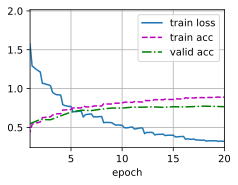

In [ ]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.5, get_net()
net(next(iter(train_iter))[0])
start_time3 = time.time()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)
time_taken = time.time() - start_time3
time_per_epoch = time_taken / num_epochs
print(f"{(time_taken):.2f} seconds to execute {num_epochs} epochs")
print(f"Therefore {time_per_epoch:.2f} seconds per epoch")